In [1]:
import pandas as pd
import numpy as np
import json
# データ可視化ライブラリ
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import re
from tqdm import tqdm_notebook as tqdm

import lightgbm as lgb
print('lightgbm version:', lgb.__version__)

from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import sklearn
print('sklearn version:', sklearn.__version__)
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from catboost import Pool

import warnings
warnings.filterwarnings('ignore')


lightgbm version: 2.3.0
sklearn version: 0.22.1


/Users/endotakeru/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('../data/raw/train2.csv')
test = pd.read_csv('../data/raw/test2.csv')

In [3]:
drop_columns = ['OpenFloor', 'Workshop', 'D', 'S', 'Studio', 'Maisonette', 'K', 'R']
train = train.drop(drop_columns, axis=1)
test = test.drop(drop_columns, axis=1)

In [5]:
y = train['y']
train = train.drop('y', axis=1)

In [6]:
scores = []
y_pred = np.zeros(test.shape[0])
kf = KFold(n_splits=5, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train):
    tr_x, va_x = train.iloc[tr_idx], train.iloc[va_idx]
    tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
    
    train_pool = Pool(tr_x, label=tr_y)
    test_pool = Pool(va_x, label=va_y)

    params = {
            'loss_function': 'RMSE',
            'iterations': 50000,
            'od_type': "Iter",
            'depth': 10,
            'colsample_bylevel': 0.5,
            'early_stopping_rounds': 300,
            'l2_leaf_reg': 18,
            'random_seed': 42,
            'use_best_model': True
    }


    model =  CatBoostRegressor(**params)
    model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=200,              
    )

    y_val_pred = model.predict(va_x)
    val_score = np.sqrt(mean_squared_error(va_y, y_val_pred))
    y_pred  += model.predict(test)
    scores.append(val_score)

print('RMSE:', np.mean(scores))


0:	learn: 308.2417000	test: 289.5976444	best: 289.5976444 (0)	total: 110ms	remaining: 1h 31m 57s
200:	learn: 170.7492622	test: 190.5715050	best: 190.5715050 (200)	total: 8.38s	remaining: 34m 35s
400:	learn: 136.3836794	test: 180.0295825	best: 180.0295825 (400)	total: 17.1s	remaining: 35m 19s
600:	learn: 117.9113891	test: 175.8113703	best: 175.7835913 (595)	total: 26.5s	remaining: 36m 15s
800:	learn: 102.9536963	test: 172.6486072	best: 172.6486072 (800)	total: 35.5s	remaining: 36m 18s
1000:	learn: 92.0862232	test: 170.8663547	best: 170.8663547 (1000)	total: 44.6s	remaining: 36m 21s
1200:	learn: 83.4566600	test: 169.8264151	best: 169.8064594 (1197)	total: 53.5s	remaining: 36m 14s
1400:	learn: 76.2999624	test: 169.1004459	best: 169.1004459 (1400)	total: 1m 2s	remaining: 36m 14s
1600:	learn: 70.4190610	test: 168.6123298	best: 168.6082716 (1599)	total: 1m 11s	remaining: 36m 11s
1800:	learn: 65.6334480	test: 168.2138592	best: 168.2097827 (1797)	total: 1m 21s	remaining: 36m 10s
2000:	learn: 6

800:	learn: 104.9990061	test: 189.0535180	best: 189.0535180 (800)	total: 35.9s	remaining: 36m 47s
1000:	learn: 94.1724455	test: 187.5778298	best: 187.5776859 (990)	total: 45s	remaining: 36m 41s
1200:	learn: 84.3647860	test: 186.4795966	best: 186.4676384 (1195)	total: 54.2s	remaining: 36m 41s
1400:	learn: 76.3464213	test: 185.7423695	best: 185.7423695 (1400)	total: 1m 3s	remaining: 36m 29s
1600:	learn: 69.6856775	test: 185.1649124	best: 185.1439676 (1598)	total: 1m 12s	remaining: 36m 16s
1800:	learn: 63.6544625	test: 184.6860956	best: 184.6860690 (1799)	total: 1m 21s	remaining: 36m 9s
2000:	learn: 58.6695453	test: 184.2137121	best: 184.2137121 (2000)	total: 1m 30s	remaining: 36m 1s
2200:	learn: 54.8228874	test: 184.0030617	best: 183.9849027 (2198)	total: 1m 39s	remaining: 35m 54s
2400:	learn: 51.3858133	test: 183.7514423	best: 183.7414222 (2390)	total: 1m 48s	remaining: 35m 45s
2600:	learn: 48.4761200	test: 183.6076788	best: 183.6036156 (2598)	total: 1m 57s	remaining: 35m 35s
2800:	lear

2200:	learn: 58.8288454	test: 221.8569331	best: 221.8569331 (2200)	total: 1m 49s	remaining: 39m 46s
2400:	learn: 54.9373100	test: 221.4503754	best: 221.4495832 (2399)	total: 1m 59s	remaining: 39m 29s
2600:	learn: 51.9822832	test: 221.2356369	best: 221.2181512 (2584)	total: 2m 10s	remaining: 39m 30s
2800:	learn: 49.1651501	test: 221.0353797	best: 221.0256919 (2796)	total: 2m 20s	remaining: 39m 34s
3000:	learn: 46.5069619	test: 220.9155708	best: 220.9066466 (2949)	total: 2m 31s	remaining: 39m 27s
3200:	learn: 44.1328189	test: 220.7077224	best: 220.7077224 (3200)	total: 2m 40s	remaining: 39m 9s
3400:	learn: 42.1249679	test: 220.6441804	best: 220.6247240 (3387)	total: 2m 50s	remaining: 38m 55s
3600:	learn: 40.3004782	test: 220.5166385	best: 220.5166385 (3600)	total: 2m 59s	remaining: 38m 32s
3800:	learn: 38.5023028	test: 220.3900862	best: 220.3887065 (3781)	total: 3m 8s	remaining: 38m 10s
4000:	learn: 36.9474270	test: 220.2833511	best: 220.2828781 (3996)	total: 3m 17s	remaining: 37m 50s
42

In [7]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = train.columns
feature_importances['importance'] = model.get_feature_importance()
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
5,Area,24.219823
25,h31_price,12.287268
8,TotalFloorArea,9.703255
15,Breadth,6.064016
7,Frontage,5.825297
2,MunicipalityCode,5.081008
18,FloorAreaRatio,4.761148
19,Period,3.656075
24,longitude,3.487319
23,latitude,2.975831


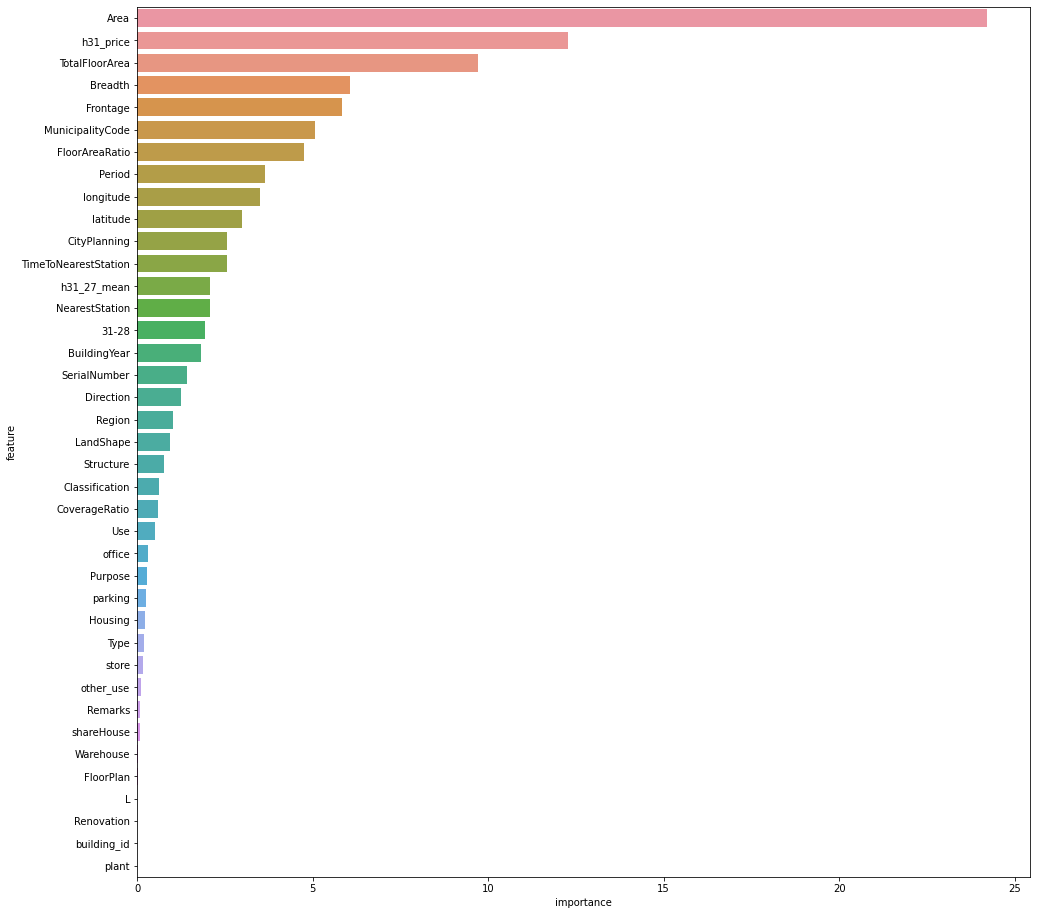

In [8]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.head(70), x='importance', y='feature')

In [9]:
y_pred_fi = y_pred / 4
y_pred_fi = np.round(y_pred_fi, 2)

In [10]:
submit = pd.read_csv('../data/raw/test_data.csv')

In [11]:
sub = pd.DataFrame({'id': submit['id'], 'y': y_pred})

In [12]:
sub.query('y < 0')

,id,y
580,581,-12.457396
582,583,-13.204943
808,809,-15.755361
1470,1471,-26.329745
1548,1549,-23.670029
...,...,...
34773,34774,-39.006517
34791,34792,-38.890407
34798,34799,-22.367863
34799,34800,-18.706020


In [13]:
for i in sub[sub['y'] < 0]['id']:
    sub['y'][i-1] = 0 

In [14]:
sub.to_csv('sub_cat_2.csv', index=False)